In [1]:
import pennylane as qml
from pennylane import numpy as npp
from matplotlib import pyplot as plt

# set the random seed
npp.random.seed(42)

# create a device to execute the circuit on
dev = qml.device("default.qubit", wires=4)

@qml.qnode(dev, diff_method="parameter-shift", interface="autograd")
def circuit(params,inputs):
    qml.RY(inputs[0], wires=0)
    qml.RY(inputs[1], wires=1)
    qml.RY(inputs[2], wires=2)
    qml.RY(inputs[3], wires=3)
    

    qml.U3(params[0],params[1],params[2], wires=0)
    qml.U3(params[3],params[4],params[5], wires=1)
    qml.U3(params[6],params[7],params[8], wires=2)
    qml.U3(params[9],params[10],params[11], wires=3)
    

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    qml.RY(inputs[0]*1.5, wires=0)
    qml.RY(inputs[1]*1.5, wires=1)
    qml.RY(inputs[2]*1.5, wires=2)
    qml.RY(inputs[3]*1.5, wires=3)

    qml.U3(params[12],params[13],params[14], wires=0)
    qml.U3(params[15],params[16],params[17], wires=1)
    qml.U3(params[18],params[19],params[20], wires=2)
    qml.U3(params[21],params[22],params[23], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2,3], pattern="ring")
    
    
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)

    qml.U3(params[24],params[25],params[26], wires=0)
    qml.U3(params[27],params[28],params[29], wires=1)
    qml.U3(params[30],params[31],params[32], wires=2)
    qml.U3(params[33],params[34],params[35], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    qml.RY(inputs[0]*2, wires=0)
    qml.RY(inputs[1]*2, wires=1)
    qml.RY(inputs[2]*2, wires=2)
    qml.RY(inputs[3]*2, wires=3)
    
    qml.U3(params[36],params[37],params[38], wires=0)
    qml.U3(params[39],params[40],params[41], wires=1)
    qml.U3(params[42],params[43],params[44], wires=2)
    qml.U3(params[45],params[46],params[47], wires=3)

    qml.broadcast(qml.CNOT, wires=[0, 1, 2, 3], pattern="ring")
    
    #return qml.expval(qml.PauliX(0) @ qml.PauliI(1)@ qml.PauliY(2)@ qml.PauliI(3))
    return qml.expval(qml.PauliX(0) @  qml.PauliY(2))

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split 
import scipy.stats as stats
import math

def norminv(x):
    return ((1.0/math.sqrt(2.0*math.pi)) * math.exp(-x*x*0.5))

def d1(S0, K, r, T, sigma, q):
    deno = (sigma * math.sqrt(T))
    if (deno==0):
        return 0
    logReturns = math.log(S0/float(K)) if ((S0/float(K)) > 0.0) else 0.0
    return (float(logReturns) + (float(r) - float(q) + float(sigma)*float(sigma)*0.5)*float(T)) / float(deno)
    
def d2(S0, K, r, T, sigma, q):
        return d1(S0, K, r, T, sigma, q)-sigma*math.sqrt(T)
        
def bsformula(callput, S0, K, r, T, sigma, q=0):
    N = stats.norm.cdf
                
    def optionValueOfCall(S0, K, r, T, sigma, q):       
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return S0*math.exp(-q*T)*N(_d1)- K*math.exp(-r*T)*N(_d2)
      
    def optionValueOfPut(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        _d2 = d2(S0, K, r, T, sigma, q)
        return float(K)*math.exp(-float(r)*float(T))*N(-_d2) - float(S0)*math.exp(-float(q)*float(T))*N(-_d1)
        
    def delta(callput, S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)        
        if callput.lower() == "call":            
            return N(_d1) * math.exp(-q*T)
        else:
            return (N(_d1)-1)* math.exp(-q*T)
    
    def vega(S0, K, r, T, sigma, q):
        _d1 = d1(S0, K, r, T, sigma, q)
        return S0  * math.sqrt(T) * norminv(_d1)  * math.exp(-q*T)
    
    if callput.lower()=="call":
        optionValue = optionValueOfCall(S0, K, r, T, sigma, q)
    else:
        optionValue = optionValueOfPut(S0, K, r, T, sigma, q)
        
    _delta = delta(callput, S0, K, r, T, sigma, q)
    _vega = vega(S0, K, r, T, sigma, q)
    
    return (optionValue, _delta, _vega)

def bsm_iv_generator(num_sample = 100,tao_bound=[0.01,2.0],  sigma_bound=[0.01,2.0], 
                     money_bound=[0.3,3.0], rr_bound=[0.01,0.2], callput='call', seed=42):
    
    # input parameters: when callput is not in 'call' or 'put', randomly generate the option price followed by root-finding methods to
    # compute the corresponding implied vol
    # return: X_input = [time,stock,rr, dividen, option_price]. Y_outpu  = volatility 
    np.random.seed(seed)
    tao_min,tao_max = tao_bound[0],tao_bound[1]
    
    sigma_min, sigma_max = sigma_bound[0],sigma_bound[1]
    moneyness_min,moneyness_max = money_bound[0],money_bound[1]
    rr_min,rr_max = rr_bound[0],rr_bound[1]
   
    

    num_sample = int(num_sample)
    xx = np.zeros([num_sample,4],dtype='float')
    
   
    xx[:,0] = np.random.uniform(sigma_min, sigma_max,xx.shape[0])
    xx[:,1] = np.random.uniform(tao_min,tao_max,xx.shape[0])
    xx[:,2] = np.random.uniform(moneyness_min,moneyness_max,xx.shape[0])
    xx[:,3] = np.random.uniform(rr_min,rr_max,xx.shape[0])
   
    
   
    strike=1.0 #fixed strike
    #callput = 'call' # call option
    v = np.zeros(xx.shape[0]) # option value
    k = np.ones(xx.shape[0]) # strike price, just in order to match the shape of v
    
    if callput in ['call','put']:        
        for i in range(0,xx.shape[0]):        
            sigma, T, S0, interest = xx[i,0],xx[i,1],xx[i,2],xx[i,3]
            ## use the Black-Schole function in compfin.py
            v[i] = bsformula(callput, S0, strike, interest, T, sigma)[0]              
            
  
    v= v.reshape(xx.shape[0],1)     
    xx_sample = np.concatenate((xx,v),axis=1) #sigma, time, s, r, v
    
    
    X_input   = xx_sample[:,1:]   # time,stock,rr, option_price
    Y_output  =  xx_sample[:,0] # sigma -implied volatility is the predictive variable.
  
    return X_input,Y_output
#  log-transformation of the option value
def logscale_vol(x_train_dat,y_train_dat,otm_lower=0.0000001):
   # input data: x_train_dat = [time,stock,rr, option_price], y_train_dat = sigma  
   
    xtv_train_log=x_train_dat.copy()    
    ytv_train_log =y_train_dat.copy()
    
    
    #v_lower[v_lower<0.0]=0.0 # V=max(S-E*exp(-rt),0)  
    xintrinsic_train=xtv_train_log[:,1]-1.0*np.exp(-1.0*xtv_train_log[:,2]*xtv_train_log[:,0])
    xintrinsic_train[xintrinsic_train<0.0]=0.0 ## \tilde{V} = max(S-E*exp(-rt),0)
    xtv_train_log[:,-1] = xtv_train_log[:,-1] -xintrinsic_train
    
    ## remove intrisinc values below the threshold (otm_lower \approx machine pricision)  
   
    ytv_train_log = ytv_train_log[~np.less(xtv_train_log[:,-1],otm_lower)]
    xtv_train_log = xtv_train_log[~np.less(xtv_train_log[:,-1],otm_lower),:]
    xtv_train_log[:,-1]=np.log(xtv_train_log[:,-1])

    return xtv_train_log,ytv_train_log 

maturity time  range:
0.5005061583846219 0.5990505142000673
Stock price  range:
0.9021675302960597 1.0999435346572262
interest rate  range:
0.030905509191042024 0.07949801161949727
option value  range:
0.05445290121551333 0.28052087657820035
sigma range:
0.30220884684944094 0.6947547746402069
(200, 4)
maturity time  range:
0.5005061583846219 0.5990505142000673
Stock price  range:
0.9021675302960597 1.0999435346572262
interest rate  range:
0.030905509191042024 0.07949801161949727
time option-value  range:
-3.0197516120408463 -1.6546552815901487
sigma range:
0.30220884684944094 0.6942601816442402
(160, 4)
Parameters: [0.70723863 0.15253904 0.57628836 0.60671505 0.42413067 0.73644424
 0.93436701 0.92556851 0.45083937 0.11323805 0.9848412  0.83889809
 0.12466268 0.92084188 0.86989636 0.51883806 0.59127544 0.3990027
 0.05476164 0.33519724 0.80285345 0.00463202 0.33349917 0.39816869
 0.5373956  0.91985562 0.34634599 0.3469532  0.73750125 0.45221794
 0.22460482 0.45243952 0.14085702 0.1763869

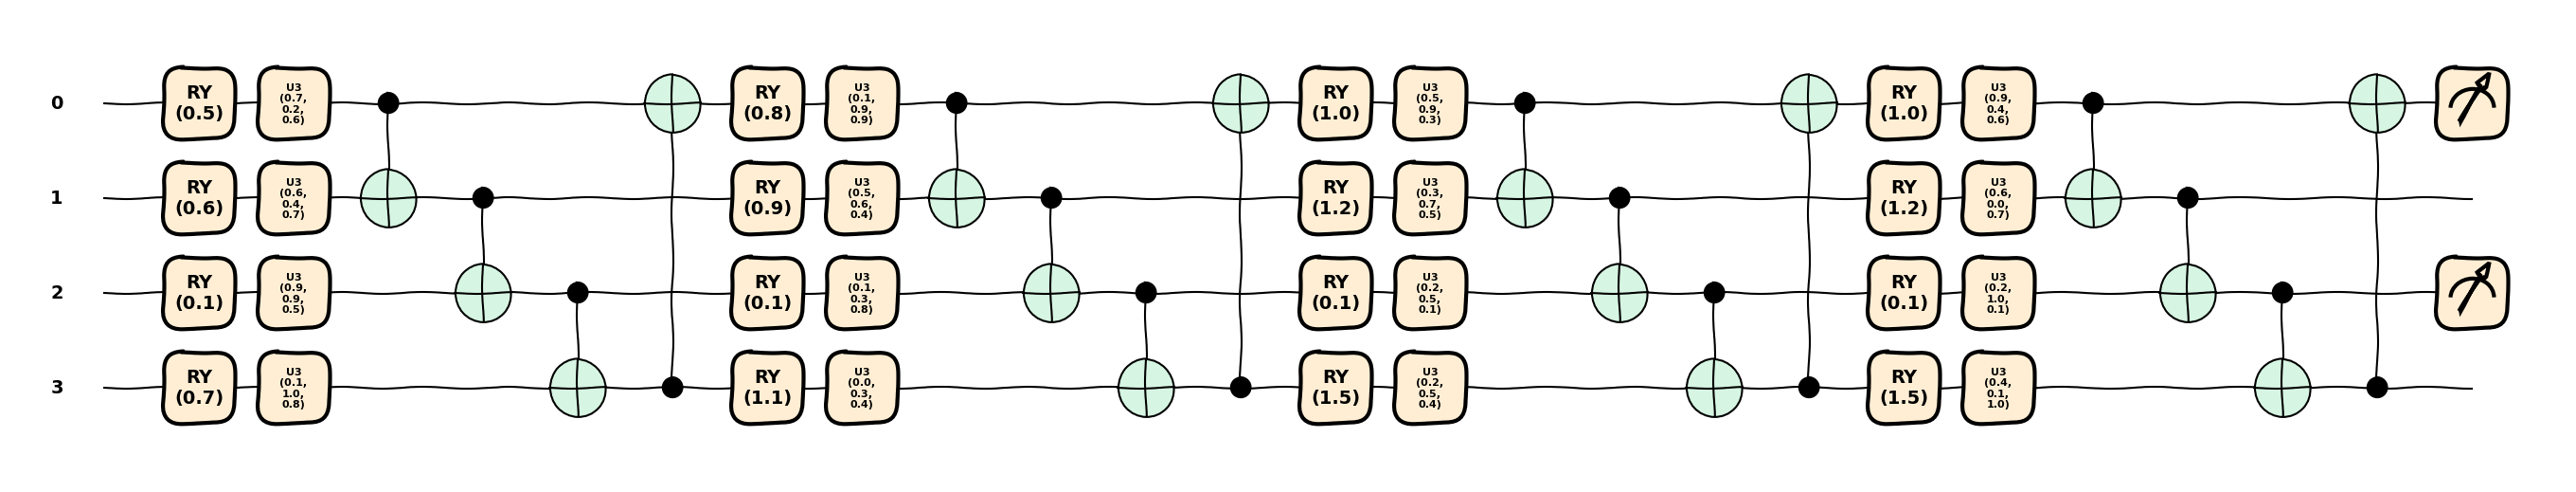

In [3]:
Xin_input,Yin_output=bsm_iv_generator(num_sample = 200,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.9,1.1], rr_bound=[0.03,0.08],callput='call')

#check the data value range on each dimension
## xin = [maturity time, Stock price, interest rate, dividend, option value]

xlabel =  ['maturity time', 'Stock price', 'interest rate','option value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(Xin_input[:,i]),np.max(Xin_input[:,i]))
    
print('sigma range:')
print(np.min(Yin_output),np.max(Yin_output))
print(np.shape(Xin_input))

# generate and shuffle the data set into training and test part
xtv_train_log_all,ytv_train_log_all=logscale_vol(Xin_input,Yin_output,otm_lower=1e-4)
'''
for i in range(4):
    xtv_train_log_all[:,i]= min_max_normalization(xtv_train_log_all[:,i])
'''
#ytv_train_log_all=ytv_train_log_all/2
xtv_train_log,xtv_test_log, ytv_train_log, ytv_test_log   = train_test_split(xtv_train_log_all,ytv_train_log_all,test_size=0.2,random_state=42)

xlabel =  ['maturity time', 'Stock price', 'interest rate','time option-value']
for i in range(0, len(xlabel)):
    print(xlabel[i]+'  range:')
    print(np.min(xtv_train_log_all[:,i]),np.max(xtv_train_log_all[:,i]))
    
print('sigma range:')
print(np.min(ytv_train_log),np.max(ytv_train_log))
## how many samples after cleaning
print(np.shape(xtv_train_log))


params = npp.random.random([48], requires_grad=True)
inputs = npp.random.random([4], requires_grad=True)
print("Parameters:", params)
print("inputs:", inputs)
print("Expectation value:", circuit(params,inputs))


qnode = qml.QNode(circuit, dev)
qml.draw_mpl(circuit, decimals=1, style="sketch")(params,inputs)
plt.show()

In [4]:
def parameter_shift_term(qnode,params,inputs, i):
    shifted = params.copy()
    shifted[i] += np.pi/2
    forward = qnode(shifted,inputs)  # forward evaluation

    shifted[i] -= np.pi
    backward = qnode(shifted,inputs) # backward evaluation

    return 0.5 * (forward - backward)

# gradient with respect to the first parameter
print(parameter_shift_term(circuit,params,inputs, 0))


def parameter_shift(qnode, params,inputs):
    gradients = np.zeros([len(params)])

    for i in range(len(params)):
        gradients[i] = parameter_shift_term(qnode,params,inputs, i)

    return gradients

print(parameter_shift(circuit, params,inputs))

grad_function = qml.grad(circuit)
print(grad_function(params,inputs)[0])


print(qml.gradients.param_shift(circuit)(params,inputs)[0])

0.23491414759184784
[ 0.23491415  0.00500436 -0.04338031 -0.01584833  0.1822473   0.09727854
  0.05644877  0.23810431  0.01555441  0.12100211  0.02224761  0.00598038
  0.05677011  0.25658389  0.23268971 -0.0345027   0.04482562  0.17487039
 -0.01230247  0.12274313  0.1268413   0.01867903  0.04748005  0.04798362
 -0.2107599   0.01991498  0.04859105 -0.34089558 -0.27806815 -0.28821049
  0.13762378  0.10425506  0.11166992 -0.00482627  0.05883212  0.04991582
 -0.00841715  0.16179834  0.11627625  0.00300985  0.22312029  0.04415785
 -0.12138687 -0.26271551 -0.24354681 -0.08956887 -0.25167051 -0.23343304]
[ 0.23491415  0.00500436 -0.04338031 -0.01584833  0.1822473   0.09727854
  0.05644877  0.23810431  0.01555441  0.12100211  0.02224761  0.00598038
  0.05677011  0.25658389  0.23268971 -0.0345027   0.04482562  0.17487039
 -0.01230247  0.12274313  0.1268413   0.01867903  0.04748005  0.04798362
 -0.2107599   0.01991498  0.04859105 -0.34089558 -0.27806815 -0.28821049
  0.13762378  0.10425506  0.11

In [5]:
from sklearn import metrics
from itertools import chain
import time
def QNN(weights, angles):
    return circuit(weights, angles)

def cost(weights, features, labels):
    predictions = [QNN(weights, f) for f in features]
    
    return square_loss(labels, predictions)

def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

def R2(labels, predictions):

    r2 = 0
    for l, p in zip(labels, predictions):
        r2 = r2 + metrics.r2_score(labels, predictions)
    r2 = r2 / len(labels)

    return r2

In [6]:
X=xtv_train_log
Y=ytv_train_log
weights_init = npp.random.random([48], requires_grad=True)
opt = qml.AdamOptimizer(0.01)
batch_size = 64
batches = len (X) // batch_size
X_batches = npp.array_split(npp.arange(len(X)) , batches)


epoch 1
-------------------------------
batch_idx: 0 loss: 0.08257501265432542 R2: -5.484538728867279 time: 1704229963.2838817
batch_idx: 1 loss: 0.07559910645531924 R2: -4.019199834892595 time: 1704230094.078085
Training [0%] Loss: 0.07908705955482233 time: 1704230094.078085
weight: [ 0.68724447  0.17255008  0.59629964  0.58685153  0.4441291   0.75636433
  0.94830184  0.90765013  0.43089078  0.09322744  0.96486386  0.81891511
  0.10474392  0.90112238  0.85017637  0.53884877  0.61127961  0.41895841
  0.07229847  0.35506228  0.82273292 -0.01531442  0.31364951  0.37832016
  0.55730443  0.9397551   0.36624033  0.36690557  0.71749092  0.44489536
  0.20472441  0.47236131  0.160782    0.15653221  0.47890785  0.39924377
  0.93224982  0.38236795  0.57687053  0.61391666 -0.00677537  0.64579658
  0.15814157  0.94108094  0.12866921  0.43389573  0.1050691   1.01658761]
epoch 2
-------------------------------
batch_idx: 0 loss: 0.04850347505225261 R2: -2.8943468359270397 time: 1704230227.4311333
ba

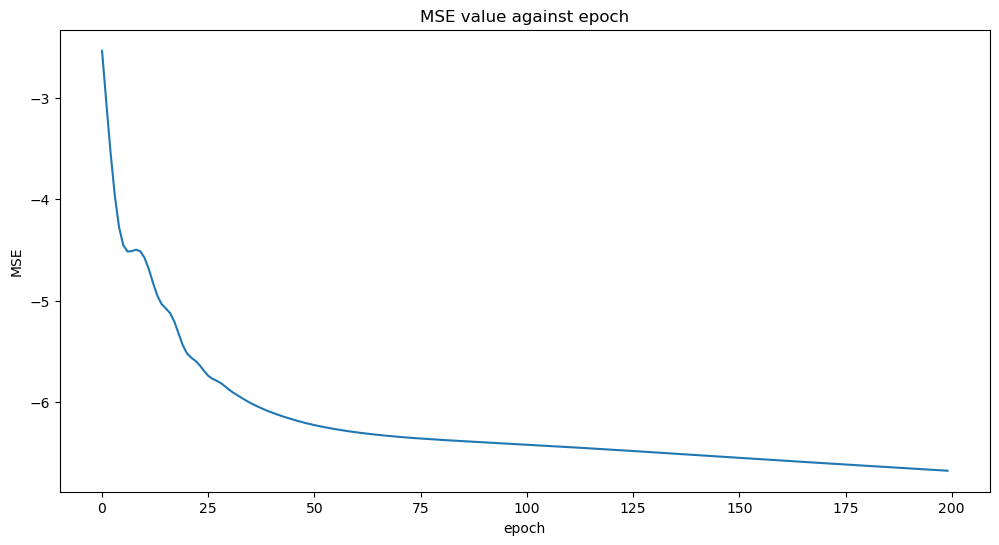

In [7]:
'''
weights =[0.68756473 , 1.2864305 ,  0.5411694 , -0.01524038 , 0.5852044 ,  0.6762012,
  0.35593897 , 0.22628789,  0.38244092,  0.35140917,  0.86482936 , 0.8531242,
  0.09241156 , 0.6720707  , 0.38071635,  0.95416117 , 0.63409   ,  0.40179932,
  0.7345088  , 0.6243114  , 0.3178202 , -0.2618623  , 0.18122938,  1.0447433,
  0.48699683 , 0.7739934  , 0.38703147 , 0.48046085,  0.5525667 ,  0.52838504,
  0.28538367 , 0.30099392,  0.74503726 , 0.67772216,  0.3839896 ,  0.417687]
weights = npp.array(weights, requires_grad=True)
'''
weights = params
loss_list=[]
r2_list=[]

n_epochs=200

start_time=time.time()
for epoch in range(n_epochs):
    total_loss  = []
    total_r2  = []
    print(f"epoch {epoch+1}\n-------------------------------")
    for it, batch_index in enumerate (chain(*[X_batches])):
        # Update the weights by one optimizer step
        
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, _, _ = opt.step(cost, weights, X_batch, Y_batch)

        # Compute accuracy
        predictions = [QNN(weights, x) for x in X]
        r2 = R2(Y, predictions)
        cost_t=cost(weights,X_batch,Y_batch)
        total_loss.append(cost_t)
        total_r2.append(r2)
        end_timet=time.time()
        print("batch_idx:",it,"loss:",cost_t,"R2:",r2,"time:",end_timet)
    loss_list.append(sum(total_loss)/len(total_loss))
    r2_list.append(sum(total_r2)/len(total_r2))
    print('Training [{:.0f}%]'.format(100. * (epoch + 1) / n_epochs),"Loss:", loss_list[-1], "time:",end_timet)
    print("weight:",weights)
    
    
predictions = [QNN(weights, x) for x in X]

train_R2 = R2(Y, predictions)
train_MSE=metrics.mean_squared_error(Y,predictions)
train_RMSE=train_MSE**(1/2)
train_MAE=metrics.mean_absolute_error(Y,predictions)
train_MAPE=metrics.mean_absolute_percentage_error(Y,predictions)

print("train_MSE:",train_MSE)
print("train_RMSE:",train_RMSE)
print("train_MAE:",train_MAE)
print("train_MAPE:",train_MAPE)
print("train_R2:",train_R2)

plt.rcParams["figure.figsize"] = (12, 6)

plt.title("MSE value against epoch")
plt.xlabel("epoch")
plt.ylabel("MSE")
plt.plot(range(len(loss_list)), np.log(loss_list))
plt.show()

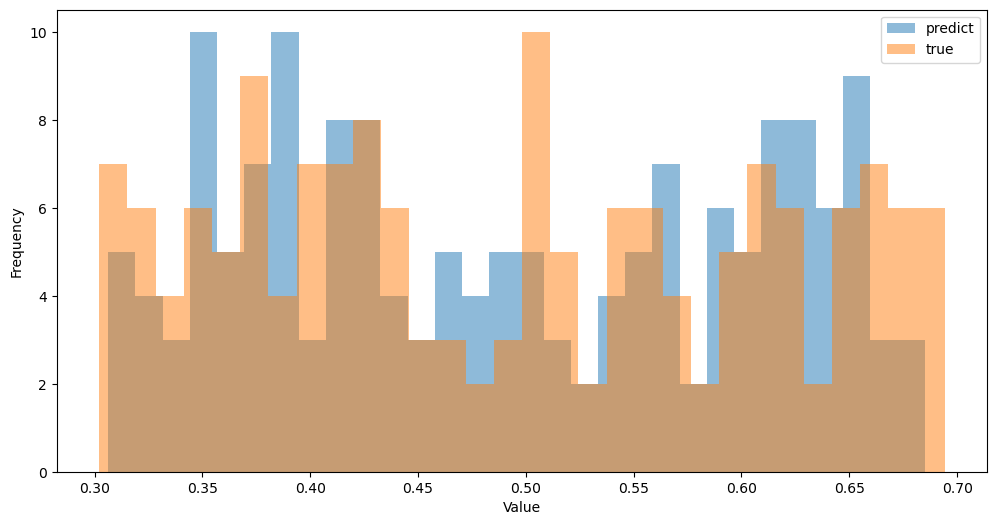

In [8]:
plt.hist(predictions, bins=30, alpha=0.5, label='predict')
plt.hist(Y, bins=30, alpha=0.5, label='true')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()

In [9]:
print(predictions)
print(Y)

[array(0.35990315), array(0.63188331), array(0.59066204), array(0.43003544), array(0.41495519), array(0.46220423), array(0.31473855), array(0.39449321), array(0.41723899), array(0.54251582), array(0.50942056), array(0.40728365), array(0.34674461), array(0.66408102), array(0.34702624), array(0.59703347), array(0.64569435), array(0.3224357), array(0.58858565), array(0.54867389), array(0.60379371), array(0.4225946), array(0.35800134), array(0.58806674), array(0.625724), array(0.51365737), array(0.39183748), array(0.40431893), array(0.39156383), array(0.48739878), array(0.63632138), array(0.64932051), array(0.53376008), array(0.46262723), array(0.6309244), array(0.60399209), array(0.43438477), array(0.63668658), array(0.33969276), array(0.40528438), array(0.64945931), array(0.36499832), array(0.38641834), array(0.49764532), array(0.65952731), array(0.37868758), array(0.56584052), array(0.36262175), array(0.31700745), array(0.38757532), array(0.35211779), array(0.42309527), array(0.61423973

In [10]:
X_test=xtv_test_log
Y_test=ytv_test_log
test_predictions = [QNN(weights, x) for x in X_test]

test_R2 = R2(Y_test, test_predictions)
test_MSE=metrics.mean_squared_error(Y_test,test_predictions)
test_RMSE=test_MSE**(1/2)
test_MAE=metrics.mean_absolute_error(Y_test,test_predictions)
test_MAPE=metrics.mean_absolute_percentage_error(Y_test,test_predictions)

print("train_MSE:",test_MSE)
print("train_RMSE:",test_RMSE)
print("train_MAE:",test_MAE)
print("train_MAPE:",test_MAPE)
print("train_R2:",test_R2)

train_MSE: 0.001818878588466189
train_RMSE: 0.04264831284431061
train_MAE: 0.03474443642540116
train_MAPE: 0.074045565910796
train_R2: 0.8689318916439849


In [11]:
X1,Y1=bsm_iv_generator(num_sample = 5000,tao_bound=[0.5,0.6],  sigma_bound=[0.3,0.7], 
                                      money_bound=[0.9,1.1], rr_bound=[0.03,0.08],callput='call')
X1,Y1=logscale_vol(X1,Y1,otm_lower=1e-4)

In [12]:

test1_predictions = [QNN(weights, x) for x in X1]

test1_R2 = R2(Y1, test1_predictions)
test1_MSE=metrics.mean_squared_error(Y1,test1_predictions)
test1_RMSE=test1_MSE**(1/2)
test1_MAE=metrics.mean_absolute_error(Y1,test1_predictions)
test1_MAPE=metrics.mean_absolute_percentage_error(Y1,test1_predictions)

print("train_MSE:",test1_MSE)
print("train_RMSE:",test1_RMSE)
print("train_MAE:",test1_MAE)
print("train_MAPE:",test1_MAPE)
print("train_R2:",test1_R2)

train_MSE: 0.001489737010449189
train_RMSE: 0.03859711142623485
train_MAE: 0.03187660238248099
train_MAPE: 0.06771286050208594
train_R2: 0.888985820279624


<function matplotlib.pyplot.show(close=None, block=None)>

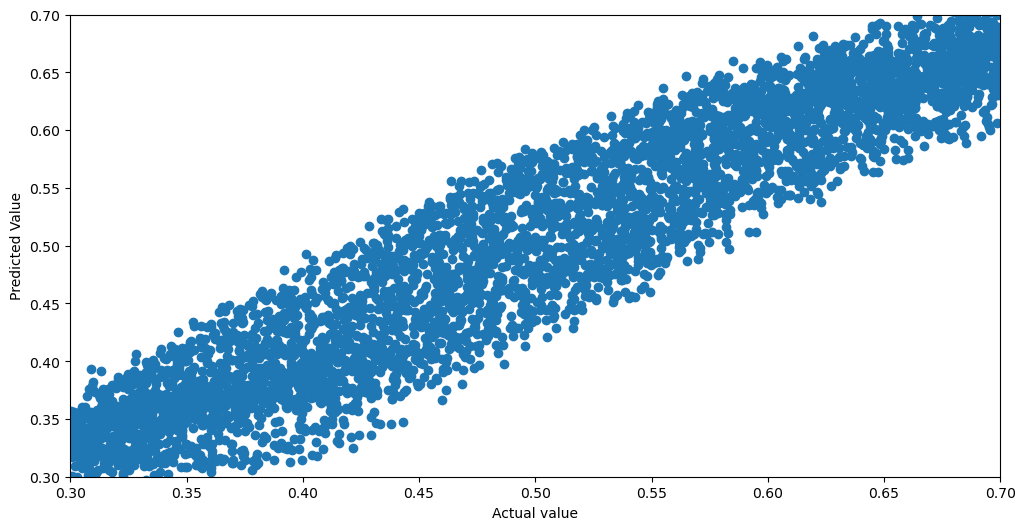

In [13]:
plt.scatter(Y1,test1_predictions)
plt.xlim(0.3,0.7)
plt.ylim(0.3,0.7)
plt.xlabel("Actual value")
plt.ylabel("Predicted Value")
plt.show